# Tomography tomorec example notebook
This notebook is an example to be used with the "Tomorec Kernel".

In [1]:
# tomopy is using internal system for compute paralelization
# set number of Intel OpenMP threads to 1, i.e. disable internal numpy&scipy paralelization
%env MKL_NUM_THREADS 1
%env OMP_NUM_THREADS 1

# ncore = None or optimal number of cores on the system
ncore = 8 # None

env: MKL_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
# Import modules
%pylab inline
import tomopy
import sirtfilter
import dxchange
import matplotlib.pyplot as plt
import h5py
import time
import tifffile
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Set the path to the micro-CT data to reconstruct.
site_data_dir = '/data/staff/kits/jasbru/expands-tomorec/' # tomograms test data at MAX IV
input_data_file = site_data_dir + 'hdf5-conversion/h11913_4_3.h5'
output_image_file = site_data_dir + 'analysis-output/gridrec_alpha15e-5.tiff'

print("Site data root directory: %s" % site_data_dir)

Site data root directory: /data/staff/kits/jasbru/expands-tomorec/


In [4]:
# load data

with h5py.File(input_data_file,'r') as fp:
    proj = fp['exchange/data'][:,800:1000,:] # [()]
    flat = fp['exchange/data_flat'][:,800:1000,:] # [()]
    dark = fp['exchange/data_dark'][:,800:1000,:] # [()]

print(proj.shape, flat.shape, dark.shape)

(1801, 200, 2560) (100, 200, 2560) (30, 200, 2560)


If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case theta is set as equally spaced between 0-180 degrees.

In [5]:
theta = tomopy.angles(proj.shape[0])

Perform the flat-field correction of raw data: $$ \frac{proj - dark} {flat - dark} $$

In [6]:
proj = tomopy.normalize(proj, flat, dark, ncore=ncore)
print(proj.shape)

(1801, 200, 2560)


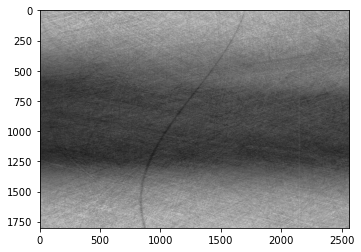

In [7]:
plt.imshow(proj[:,40, :], cmap='Greys_r')
plt.show()

Tomopy provides various methods to [find rotation center](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.rotation.html).

In [8]:
### we skip the rot center calculation because we know the rotation center is at 1280
#rot_center = tomopy.find_center(proj, theta, init=1280, ind=0, tol=0.5)
#print(rot_center)
rot_center=1280

In [9]:
proj=tomopy.prep.phase.retrieve_phase(proj,pixel_size=0.00016,dist=19,energy=21,alpha=0.0001,pad=True,ncore=ncore)

Reconstruction using Gridrec algorithm.Tomopy provides various [reconstruction](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html) methods including the one part of the [ASTRA toolbox](https://sourceforge.net/p/astra-toolbox/wiki/Home/).

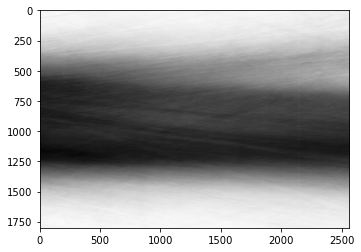

In [10]:
plt.imshow(proj[:, 40,:], cmap='Greys_r')
plt.show()

Calculate $$ -log(proj) $$

In [11]:
proj = tomopy.minus_log(proj, ncore=ncore)

# Padding to remove the gradient around the FOV in the reconstruction

In [12]:
N = proj.shape[2]
proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
proj_pad[:,:,N//4:5*N//4] = proj
proj_pad[:,:,0:N//4] = np.tile(np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))
proj_pad[:,:,5*N//4:] = np.tile(np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))

proj = proj_pad
rot_center = rot_center+N//4

# select / define tomo algorithms

In [13]:
def rec_sirtfbp(data, theta, rot_center, start=0, test_sirtfbp_iter = False, ncore=None):

    # Use test_sirtfbp_iter = True to test which number of iterations is suitable for your dataset
    # Filters are saved in .mat files in "site_data_dir/tmp/"
    if test_sirtfbp_iter:
        nCol = data.shape[2]
        output_name = site_data_dir+'/tmp/test_iter/'
        num_iter = [50,100,150]
        filter_dict = sirtfilter.getfilter(nCol, theta, num_iter, filter_dir=site_data_dir+'/tmp/', ncore=ncore)
        for its in num_iter:
            tomopy_filter = sirtfilter.convert_to_tomopy_filter(filter_dict[its], nCol)
            rec = tomopy.recon(data, theta, center=rot_center, algorithm='gridrec', filter_name='custom2d', filter_par=tomopy_filter, ncore=ncore)
            output_name_2 = output_name + 'sirt_fbp_%iiter_slice_' % its
            dxchange.write_tiff_stack(data, fname=output_name_2, start=start, dtype='float32')

    # Reconstruct object using sirt-fbp algorithm:
    num_iter = 100
    nCol = data.shape[2]
    sirtfbp_filter = sirtfilter.getfilter(nCol, theta, num_iter, filter_dir=site_data_dir+'/tmp/', ncore=ncore)
    tomopy_filter = sirtfilter.convert_to_tomopy_filter(sirtfbp_filter, nCol)
    rec = tomopy.recon(data, theta, center=rot_center, algorithm='gridrec', filter_name='custom2d', filter_par=tomopy_filter, ncore=ncore)
    
    return rec

In [14]:
algorithm = 'gridrec'
#algorithm = 'sirtfbp'

In [15]:
slice_first=0 #0 #500
slice_last=proj.shape[1] #501
aproj=proj[:,slice_first:slice_last,:]
print(aproj.shape)

(1801, 200, 3840)


In [16]:
if algorithm == 'sirtfbp':
    recon = rec_sirtfbp(aproj, theta, rot_center, ncore=ncore)
else:
    recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, filter_name='parzen', ncore=ncore)
recon = recon[:,N//4:5*N//4,N//4:5*N//4]
        
print("Algorithm: ", algorithm)

Reconstructing 8 slice groups with 8 master threads...
Algorithm:  gridrec


print(recon.shape)

In [17]:
print(recon.shape)

(200, 2560, 2560)


Mask each reconstructed slice with a circle.

In [18]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, ncore=ncore)

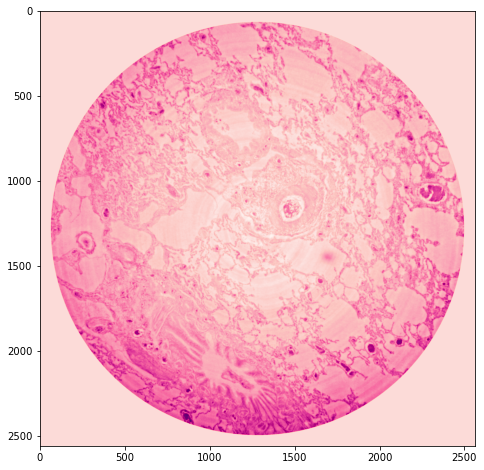

In [19]:
plt.figure(figsize=(9,8))
plt.imshow(recon[30,:,:], cmap='RdPu') 
plt.show()

In [20]:
tifffile.imsave(output_image_file,recon)